In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.tsa.stattools import acf, pacf

In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
from pmdarima.arima import auto_arima

In [132]:
#import NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")

In [133]:
#understand data format and clean up data 
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2705, freq=None)

In [134]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [135]:
df.head()


,Close,year,month,day
Date,,,,
2010-01-04,2308.419922,2010,1,4
2010-01-05,2308.709961,2010,1,5
2010-01-06,2301.090088,2010,1,6
2010-01-07,2300.050049,2010,1,7
2010-01-08,2317.169922,2010,1,8


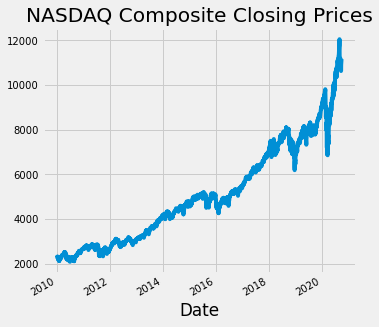

In [136]:
#plot NASDAQ trend 
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(5,5), title= 'NASDAQ Composite Closing Prices', fontsize=10)

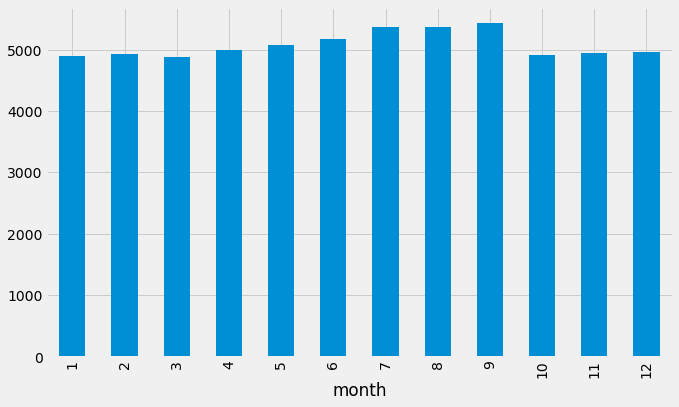

In [137]:
df.groupby('month')['Close'].mean().plot.bar()
#on average, september has the highest average price compares to the other months. 

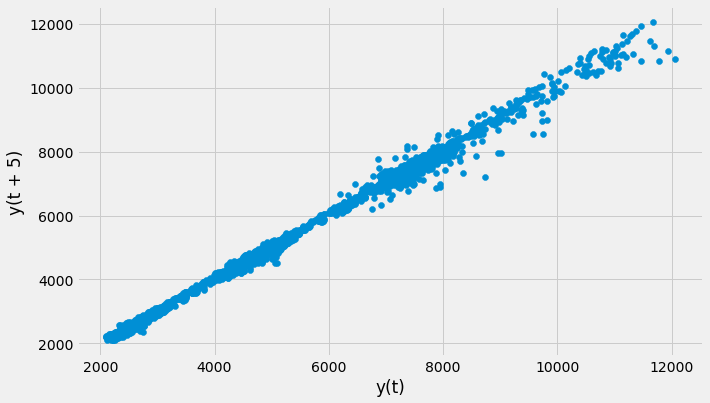

In [138]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)

#Graph shows a linear pattern. Implies data points are non random and suggests that an autoregressive model might be appropriate.

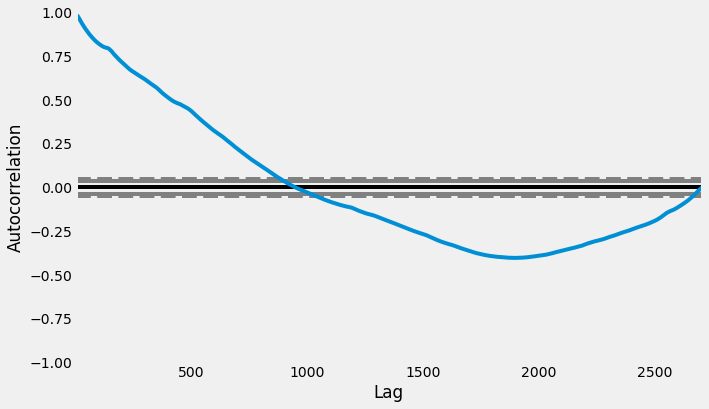

In [139]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#there is high level of correlation 

In [140]:
#data is not stationary based on high p value
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: 1.4430465972942679
p-value:0.9973011850493003


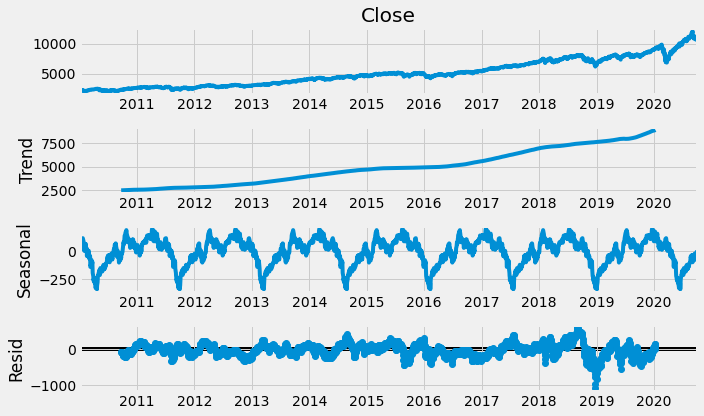

In [141]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#data shows upward trend and presents seasonlity

In [142]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=50):
    plt.plot(x,y)
    plt.show()

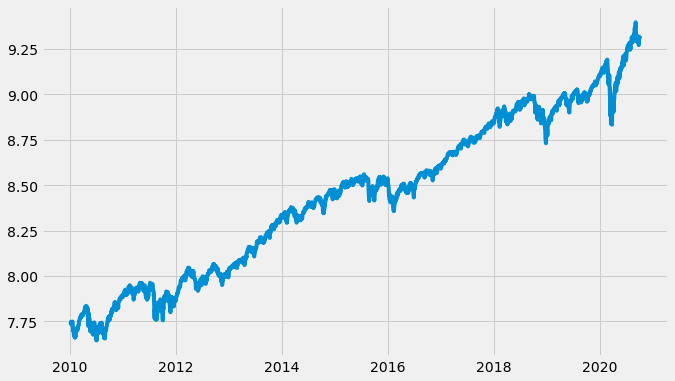

In [143]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

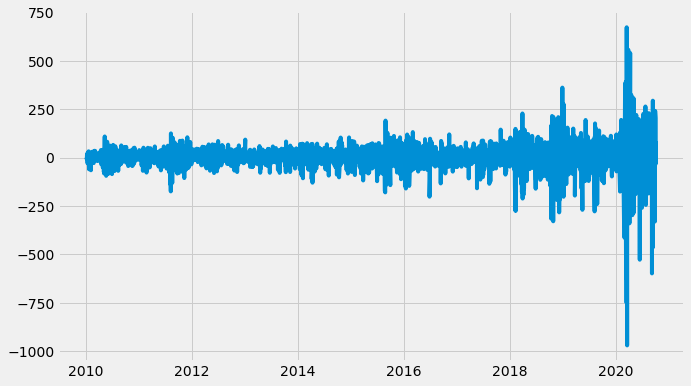

In [144]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [145]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -11.770291597674845
p-value:1.0940406662618215e-21


In [146]:
df_st= df.diff(1).fillna(0)

In [147]:
import time

t = time.process_time()

In [148]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.000000,0.0,0.0,0.0
2010-01-05,0.290039,0.0,0.0,1.0
2010-01-06,-7.619873,0.0,0.0,1.0
2010-01-07,-1.040039,0.0,0.0,1.0
2010-01-08,17.119873,0.0,0.0,1.0


In [149]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_revert=df_st.copy()
df_revert=df_revert.cumsum()

In [150]:
df_revert.iloc[0,:]=df.iloc[0,:]
df_revert = df_revert.cumsum()


In [151]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.revert = self.revert(self.stationary, self.data)
        
    def revert(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [152]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.8))])
x_test = TimeSeriesData(df[int((len(df)*0.8)):])


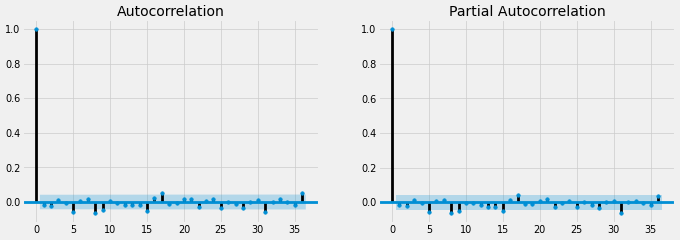

In [153]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi= 50)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=36, ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=36, ax=axes[1]);

In [154]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22406.770, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22400.729, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22402.090, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22402.065, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22406.532, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22393.839, Time=1.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22404.619, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22404.702, Time=0.83 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22402.822, Time=0.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=22402.801, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=22406.446, Time=0.28 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.629 seconds


ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [155]:
model_arima = ARIMA(x_train.data['Close'].values, order=(1,1,1))

In [156]:
result_arima = model_arima.fit(disp=-1)

In [157]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2163
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11192.925
Method:                       css-mle   S.D. of innovations             42.767
Date:                Fri, 04 Dec 2020   AIC                          22393.851
Time:                        19:12:02   BIC                          22416.568
Sample:                             1   HQIC                         22402.159
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5691      0.570      4.506      0.000       1.452       3.687
ar.L1.D.y      0.9330      0.027     34.756      0.000       0.880       0.986
ma.L1.D.y     -0.9587      0.021    -45.615      0.0

In [158]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

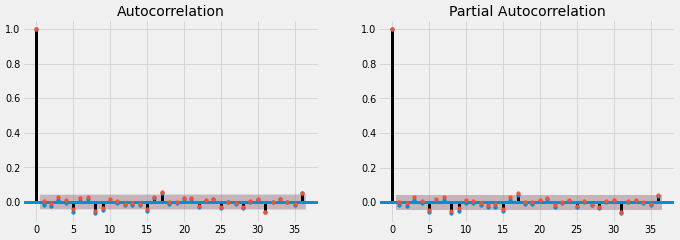

In [159]:
plot_acf(residuals, lags=36, ax=axes[0])
plot_pacf(residuals, lags=36, ax=axes[1])

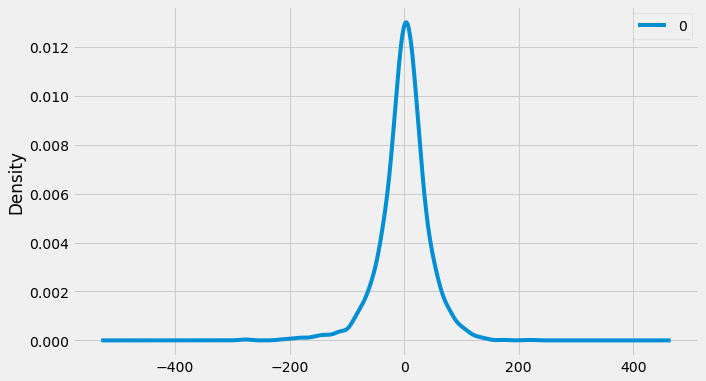

In [160]:
residuals.plot(kind='kde')

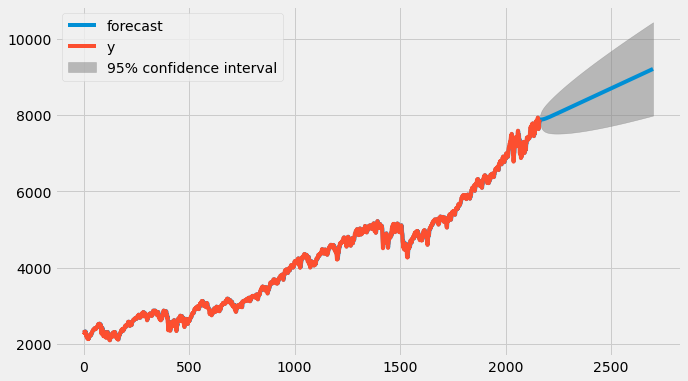

In [161]:
result_arima.plot_predict(1,2700);

In [162]:
prediction = result_arima.predict(len(df)-200,len(df)-1)


In [163]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
mse = mean_squared_error(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)

Results of sklearn.metrics:
MAE: 690.3840484817343
MSE: 791528.2196244474
RMSE: 889.678717079625


In [164]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])

7.997544256633192

In [165]:
elapsed_time = time.process_time() - t
print(elapsed_time)

18.974526218007668


In [37]:
#same analysis for TSX price

In [166]:
#upload TSX price
df=pd.read_csv("GSPTSE_v1.csv", sep=",")

In [167]:
#understand the data and covert date format
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30'],
              dtype='datetime64[ns]', name='Date', length=2697, freq=None)

In [168]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [169]:
df.head()

,Close,year,month,day
Date,,,,
2010-01-04,11866.90039,2010,1,4
2010-01-05,11888.09961,2010,1,5
2010-01-06,11944.50000,2010,1,6
2010-01-07,11887.50000,2010,1,7
2010-01-08,11953.79981,2010,1,8


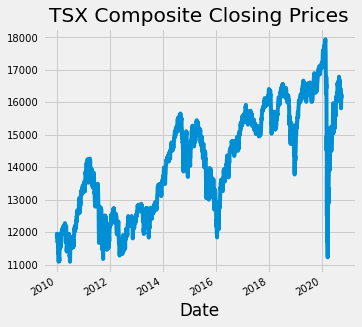

In [170]:
#plot TSX trend
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(5,5), title= 'TSX Composite Closing Prices', fontsize=10)

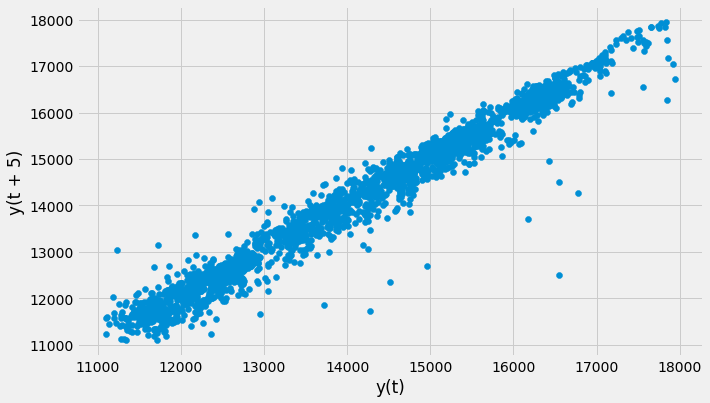

In [171]:
#lag plot
from pandas.plotting import lag_plot
lag_plot(df['Close'],lag=5)
#a linear plot also indicates non random dataset

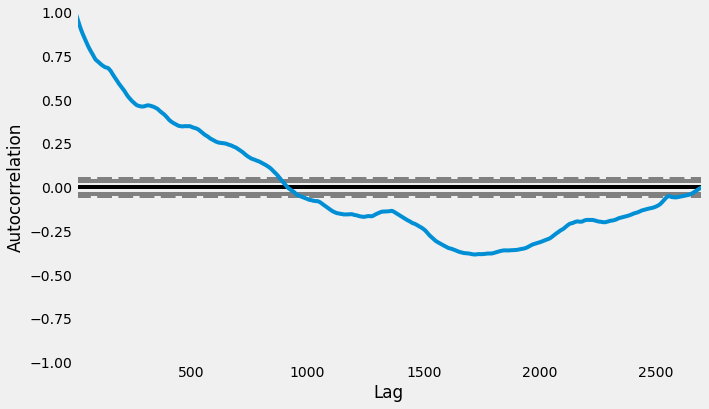

In [172]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Close'])
#autocorrelation suggests arima might be a good model

In [173]:
#original data shows as not stationary due to high p level
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -2.1272017170757755
p-value:0.23371823999228158


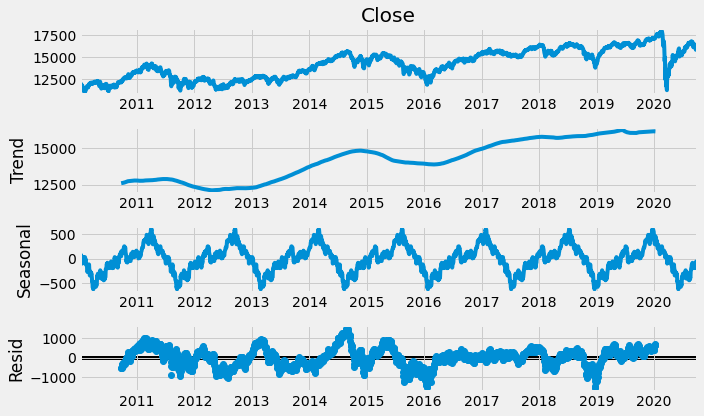

In [174]:
#decompose data
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df['Close'],model= 'addictive',period = 365)
resplot = res.plot()
#upward trend

In [175]:
def plot_df(df,x,y,title= "", xlabel = "Date", ylabel='Value',dpi=50):
    plt.plot(x,y)
    plt.show()

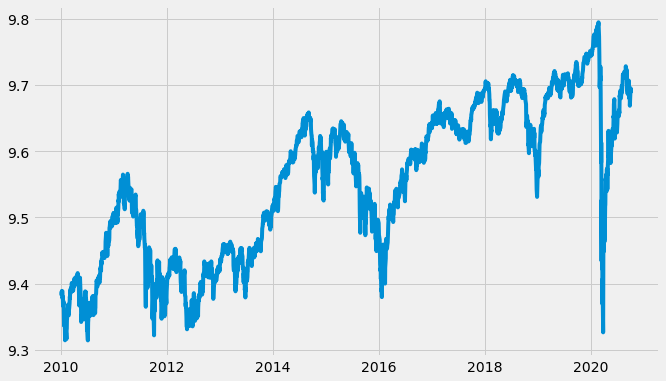

In [176]:
#apply log transformation to stablize data
plt.plot(df.apply(np.log)['Close'])

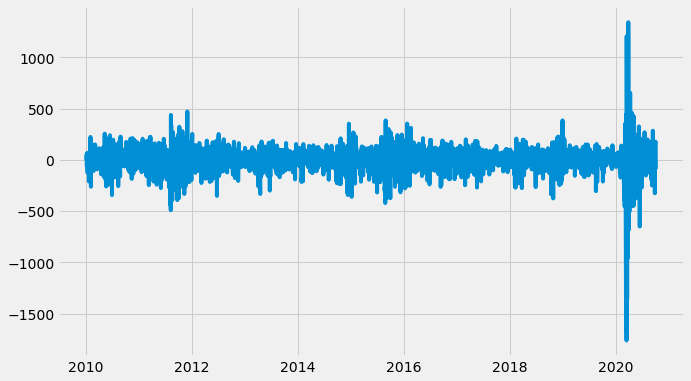

In [177]:
#To covert data into stationary dataset, first differencing has to be applied. With first differencing, empty field needs to be filled as 0. 
plt.plot(df['Close'].diff(1).fillna(0))


In [178]:
#confirm stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(df['Close']).diff(1).fillna(0))
print(f"ADF Statstic: {result[0]}")
print(f"p-value:{result[1]}")

ADF Statstic: -10.92108896454532
p-value:1.037610106877016e-19


In [179]:
import time

t = time.process_time()

In [180]:
df_st= df.diff(1).fillna(0)

In [181]:
#understand the structure of the stationary dataset
df_st.head()

,Close,year,month,day
Date,,,,
2010-01-04,0.00000,0.0,0.0,0.0
2010-01-05,21.19922,0.0,0.0,1.0
2010-01-06,56.40039,0.0,0.0,1.0
2010-01-07,-57.00000,0.0,0.0,1.0
2010-01-08,66.29981,0.0,0.0,1.0


In [182]:
#With transformation to maintain stationarity, we need to be model back to the original dataset in order to predict stock price. 
df_revert=df_st.copy()
df_revert=df_revert.cumsum()

In [183]:
df_revert.iloc[0,:]=df.iloc[0,:]
df_revert = df_revert.cumsum()

In [184]:
#define data
class TimeSeriesData():
    def __init__(self, df):
        self.data = df 
        self.stationary = self.stationarize(df)
        self.revert = self.revert(self.stationary, self.data)
        
    def revert(self, st, org):
        x = st.copy()
        x.iloc[0,:] = org.iloc[0,:]
        return x.cumsum()
    
    def stationarize(self, data):
        return data.diff(1).fillna(0)

In [185]:
#split dataset
x_train = TimeSeriesData(df[:int((len(df)*0.85))])
x_test = TimeSeriesData(df[int((len(df)*0.85)):])

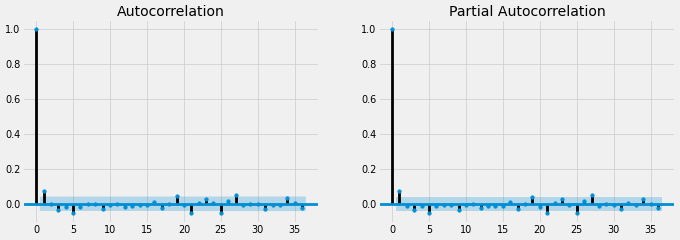

In [186]:
#plot ACF and PACF for the stationary dataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2,figsize=(15,5), dpi= 50)
plot_acf(x_train.stationary['Close'].values.tolist(), lags=36,ax=axes[0]);
plot_pacf(x_train.stationary['Close'].values.tolist(), lags=36,ax=axes[1]);

In [187]:
#using auto_arima to aquire p and q value with min AIC. 
from pmdarima import auto_arima
model = auto_arima(x_train.data['Close'], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(x_train.data['Close'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=27707.940, Time=1.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27722.152, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27711.070, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27711.001, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27720.872, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=27714.994, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=27707.115, Time=1.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27712.993, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27712.917, Time=0.16 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=27707.866, Time=1.59 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27712.282, Time=0.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=27708.220, Time=2.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=27706.090, Time=0.43 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=27711.613, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [188]:
model_arima = ARIMA(x_train.data['Close'].values, order=(2,1,1))

In [189]:
result_arima = model_arima.fit(disp=-1)

In [190]:
print(result_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2291
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -13848.621
Method:                       css-mle   S.D. of innovations            102.089
Date:                Fri, 04 Dec 2020   AIC                          27707.242
Time:                        19:12:38   BIC                          27735.926
Sample:                             1   HQIC                         27717.702
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7918      1.819      0.985      0.325      -1.773       5.357
ar.L1.D.y      0.9619      0.058     16.567      0.000       0.848       1.076
ar.L2.D.y     -0.0939      0.021     -4.491      0.0

In [191]:
#understand residual 
residuals = pd.DataFrame(result_arima.resid)

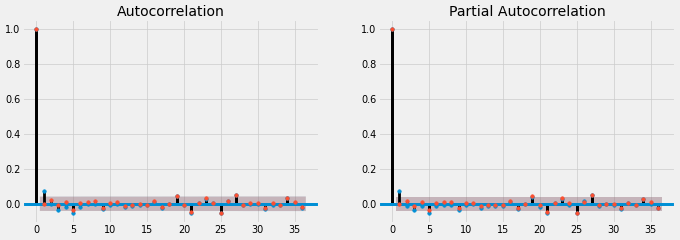

In [192]:
plot_acf(residuals, lags=36, ax=axes[0])
plot_pacf(residuals, lags=36, ax=axes[1])

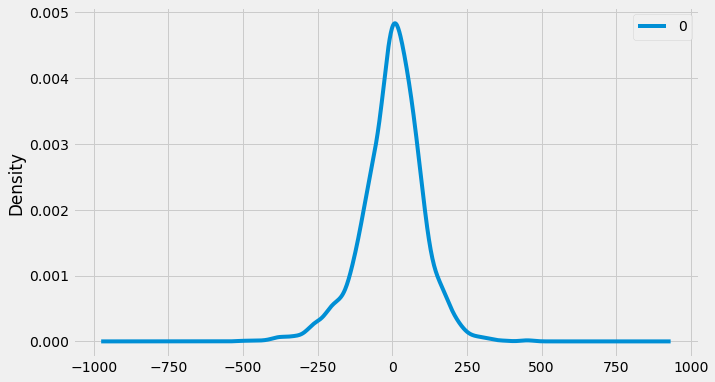

In [193]:
residuals.plot(kind='kde')

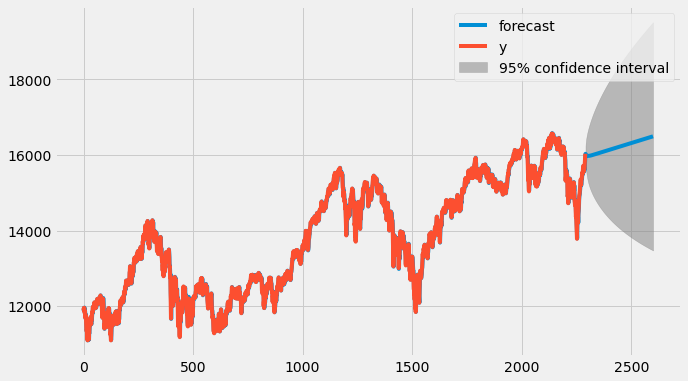

In [194]:
result_arima.plot_predict(1,2600);

In [195]:

prediction = result_arima.predict(len(df)-208,len(df)-1)


In [196]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
mse = mean_squared_error(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)

Results of sklearn.metrics:
MAE: 767.5063223410224
MSE: 1313293.7357536359
RMSE: 1145.9902860642562


In [197]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(x_test.data['Close'], np.append(x_train.data.iloc[-1,:]['Close'], prediction).cumsum()[1:])

4.863946788376522

In [198]:
elapsed_time = time.process_time() - t
print(elapsed_time)

34.980218798998976


In [70]:
#using LSTM to predict stock price

In [71]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [72]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [74]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [75]:
from pandas_datareader import data
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout

In [76]:
#similar to before, upload NASDAQ data
df=pd.read_csv("IXIC_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [77]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [78]:
#start calculating runtime in seconds
import time

t = time.process_time()

In [79]:
#scale and reshape data
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [80]:
#add layers
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.15))
regressor.add(Dense(units = 1))

In [81]:
#add optimizer and build model
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 1000, batch_size = 80)

Epoch 1/1000
34/34 [==============================] - 6s 163ms/step - loss: 0.0205
Epoch 2/1000
34/34 [==============================] - 5s 154ms/step - loss: 0.0024
Epoch 3/1000
34/34 [==============================] - 5s 151ms/step - loss: 0.0017
Epoch 4/1000
34/34 [==============================] - 5s 151ms/step - loss: 0.0015
Epoch 5/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0016
Epoch 6/1000
34/34 [==============================] - 5s 151ms/step - loss: 0.0015
Epoch 7/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0017
Epoch 8/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0016
Epoch 9/1000
34/34 [==============================] - 5s 151ms/step - loss: 0.0015
Epoch 10/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0013
Epoch 11/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0013
Epoch 12/1000
34/34 [==============================] - 5s 152ms/step - loss: 0.0014
E

In [82]:
#train the model
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [83]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

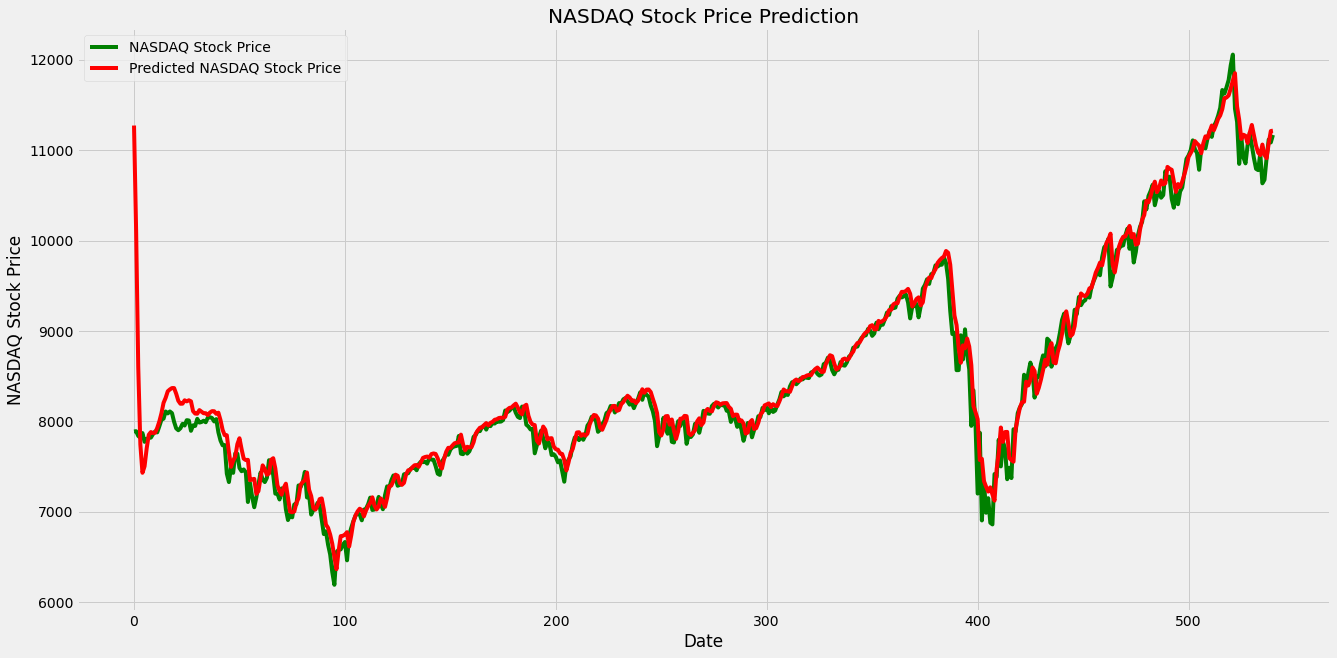

In [84]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'NASDAQ Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted NASDAQ Stock Price')
plt.title('NASDAQ Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Stock Price')
plt.legend()
plt.show()

In [85]:
rmse_predict= np.reshape(predicted_stock_price,541)

In [86]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(test["Close"].values,rmse_predict)

1.3944491323928099

In [87]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(test["Close"].values, rmse_predict)
mse = mean_squared_error(test["Close"].values, rmse_predict)
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)



Results of sklearn.metrics:
MAE: 117.05387249162432
MSE: 55267.551367822314
RMSE: 235.09051739239146


In [88]:
elapsed_time = time.process_time() - t
print(elapsed_time)

15092.296083494


In [ ]:
#using GRU to predict NASDAQ

In [89]:
import time

t = time.process_time()

In [90]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(Dense(units = 1))

In [91]:
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')

In [92]:
regressorGRU.fit(X_train, y_train, epochs = 1000, batch_size = 32)

Epoch 1/1000
83/83 [==============================] - 13s 154ms/step - loss: 0.0093
Epoch 2/1000
83/83 [==============================] - 12s 145ms/step - loss: 0.0015
Epoch 3/1000
83/83 [==============================] - 12s 142ms/step - loss: 0.0013
Epoch 4/1000
83/83 [==============================] - 13s 153ms/step - loss: 0.0012
Epoch 5/1000
83/83 [==============================] - 12s 142ms/step - loss: 0.0010
Epoch 6/1000
83/83 [==============================] - 12s 141ms/step - loss: 0.0010
Epoch 7/1000
83/83 [==============================] - 12s 140ms/step - loss: 9.9972e-04
Epoch 8/1000
83/83 [==============================] - 12s 139ms/step - loss: 0.0011
Epoch 9/1000
83/83 [==============================] - 12s 139ms/step - loss: 9.3036e-04
Epoch 10/1000
83/83 [==============================] - 12s 139ms/step - loss: 9.1217e-04
Epoch 11/1000
83/83 [==============================] - 12s 139ms/step - loss: 9.8571e-04
Epoch 12/1000
83/83 [==============================] - 11s

In [93]:
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [94]:
predicted_with_gru = regressorGRU.predict(X_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

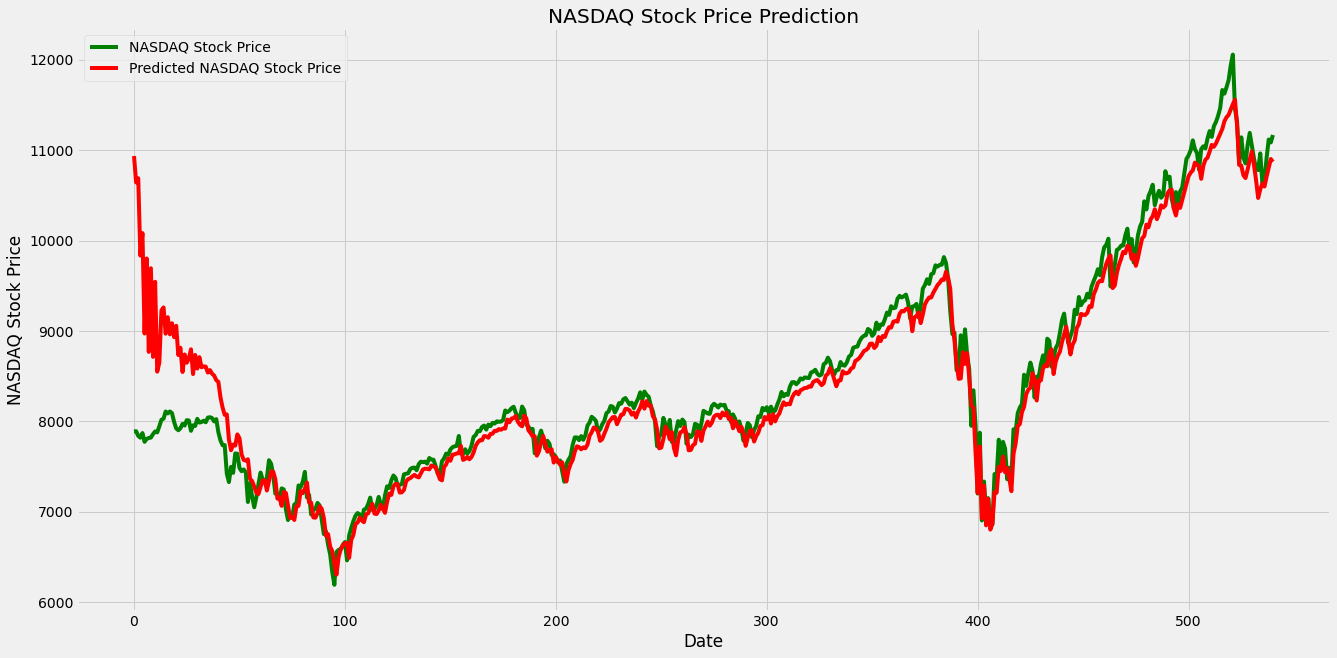

In [95]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'NASDAQ Stock Price')
plt.plot(predicted_with_gru, color = 'red', label = 'Predicted NASDAQ Stock Price')
plt.title('NASDAQ Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('NASDAQ Stock Price')
plt.legend()
plt.show()

In [96]:
rmse_predict1= np.reshape(predicted_with_gru,541)

In [97]:
#forecast metrics
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(test["Close"].values,rmse_predict1)

2.4953968614719706

In [98]:
#forecast metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(test["Close"].values, rmse_predict1)
mse = mean_squared_error(test["Close"].values, rmse_predict1)
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)


Results of sklearn.metrics:
MAE: 214.1805178292514
MSE: 148283.06866175527
RMSE: 385.07540646184515


In [99]:
elapsed_time = time.process_time() - t
print(elapsed_time)

31677.686889071


In [100]:
#repeat the same process for TSX
df=pd.read_csv("GSPTSE_v1.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[2164:]
train = df[:2163]

In [101]:
df['Date'] = df.index
data2 = pd.DataFrame(columns = ['Date', 'Close'])
data2['Date'] = df['Date']
data2['Close'] = df['Close']

In [102]:
import time

t = time.process_time()

In [103]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [104]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.15))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.15))
regressor.add(Dense(units = 1))

In [105]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 1000, batch_size = 32)

Epoch 1/1000
83/83 [==============================] - 11s 134ms/step - loss: 0.0201
Epoch 2/1000
83/83 [==============================] - 11s 129ms/step - loss: 0.0061
Epoch 3/1000
83/83 [==============================] - 11s 129ms/step - loss: 0.0059
Epoch 4/1000
83/83 [==============================] - 11s 129ms/step - loss: 0.0048
Epoch 5/1000
83/83 [==============================] - 11s 129ms/step - loss: 0.0042
Epoch 6/1000
83/83 [==============================] - 11s 127ms/step - loss: 0.0041
Epoch 7/1000
83/83 [==============================] - 11s 127ms/step - loss: 0.0035
Epoch 8/1000
83/83 [==============================] - 10s 126ms/step - loss: 0.0033
Epoch 9/1000
83/83 [==============================] - 10s 124ms/step - loss: 0.0034
Epoch 10/1000
83/83 [==============================] - 10s 124ms/step - loss: 0.0032
Epoch 11/1000
83/83 [==============================] - 10s 125ms/step - loss: 0.0029
Epoch 12/1000
83/83 [==============================] - 10s 126ms/step - lo

In [106]:
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 593):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [107]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

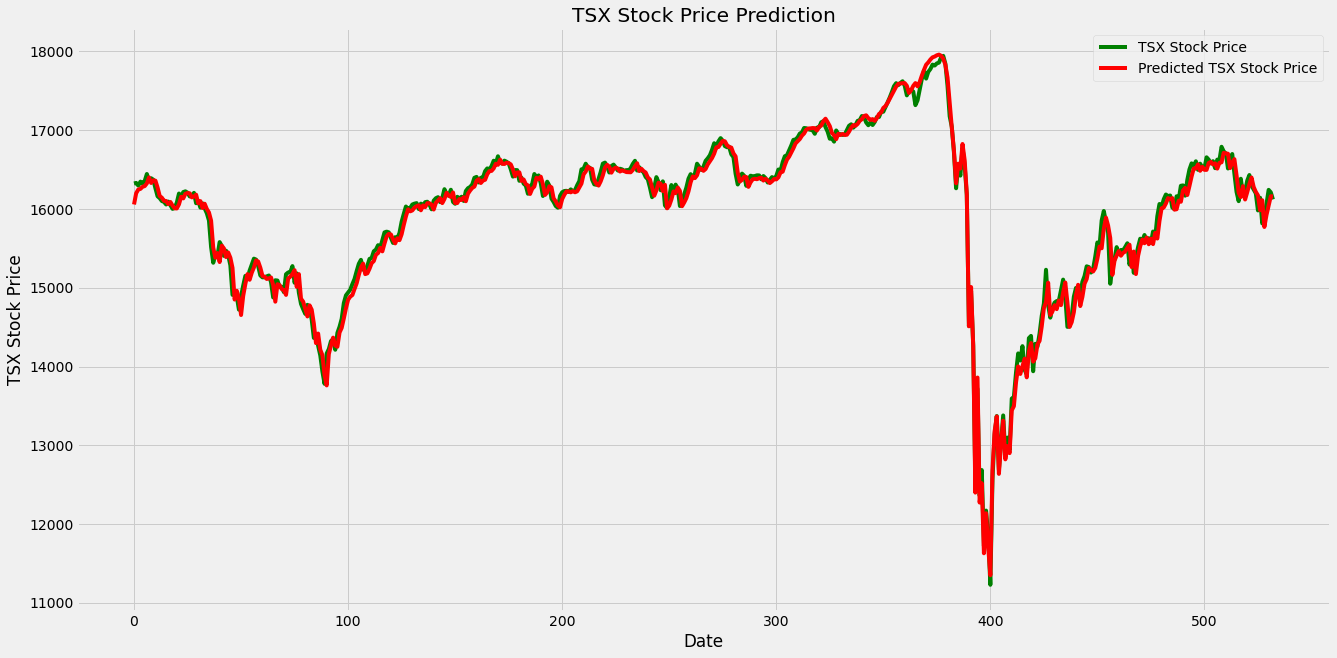

In [108]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'TSX Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted TSX Stock Price')
plt.title('TSX Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TSX Stock Price')
plt.legend()
plt.show()

In [109]:
rmse_predict= np.reshape(predicted_stock_price,533)

In [110]:
#forecast metrics
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(test["Close"].values,rmse_predict)

0.534842510006781

In [111]:
#forecast metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(test["Close"].values, rmse_predict)
mse = mean_squared_error(test["Close"].values, rmse_predict)
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)


Results of sklearn.metrics:
MAE: 83.77830782070818
MSE: 12129.751352569736
RMSE: 110.13515039518371


In [112]:

elapsed_time = time.process_time() - t
print(elapsed_time)

30921.342013751993


In [113]:
import time

t = time.process_time()

In [114]:
regressorGRU = Sequential()
regressorGRU.add(GRU(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50, return_sequences = True))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(GRU(units = 50))
regressorGRU.add(Dropout(0.15))
regressorGRU.add(Dense(units = 1))

In [115]:
regressorGRU.compile(optimizer='adam',loss='mean_squared_error')

In [116]:
regressorGRU.fit(X_train, y_train, epochs = 1000, batch_size = 32)

Epoch 1/1000
83/83 [==============================] - 13s 154ms/step - loss: 0.0207
Epoch 2/1000
83/83 [==============================] - 12s 145ms/step - loss: 0.0035
Epoch 3/1000
83/83 [==============================] - 13s 155ms/step - loss: 0.0032
Epoch 4/1000
83/83 [==============================] - 12s 141ms/step - loss: 0.0030
Epoch 5/1000
83/83 [==============================] - 12s 141ms/step - loss: 0.0029
Epoch 6/1000
83/83 [==============================] - 11s 138ms/step - loss: 0.0025
Epoch 7/1000
83/83 [==============================] - 11s 134ms/step - loss: 0.0026
Epoch 8/1000
83/83 [==============================] - 11s 132ms/step - loss: 0.0023
Epoch 9/1000
83/83 [==============================] - 11s 132ms/step - loss: 0.0021
Epoch 10/1000
83/83 [==============================] - 11s 132ms/step - loss: 0.0021
Epoch 11/1000
83/83 [==============================] - 11s 131ms/step - loss: 0.0021
Epoch 12/1000
83/83 [==============================] - 11s 130ms/step - lo

In [117]:
testdataframe= test
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date','Close'])
testdata['Date'] = testdataframe['Date']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Close'], testdata['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [118]:
predicted_with_gru = regressorGRU.predict(X_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

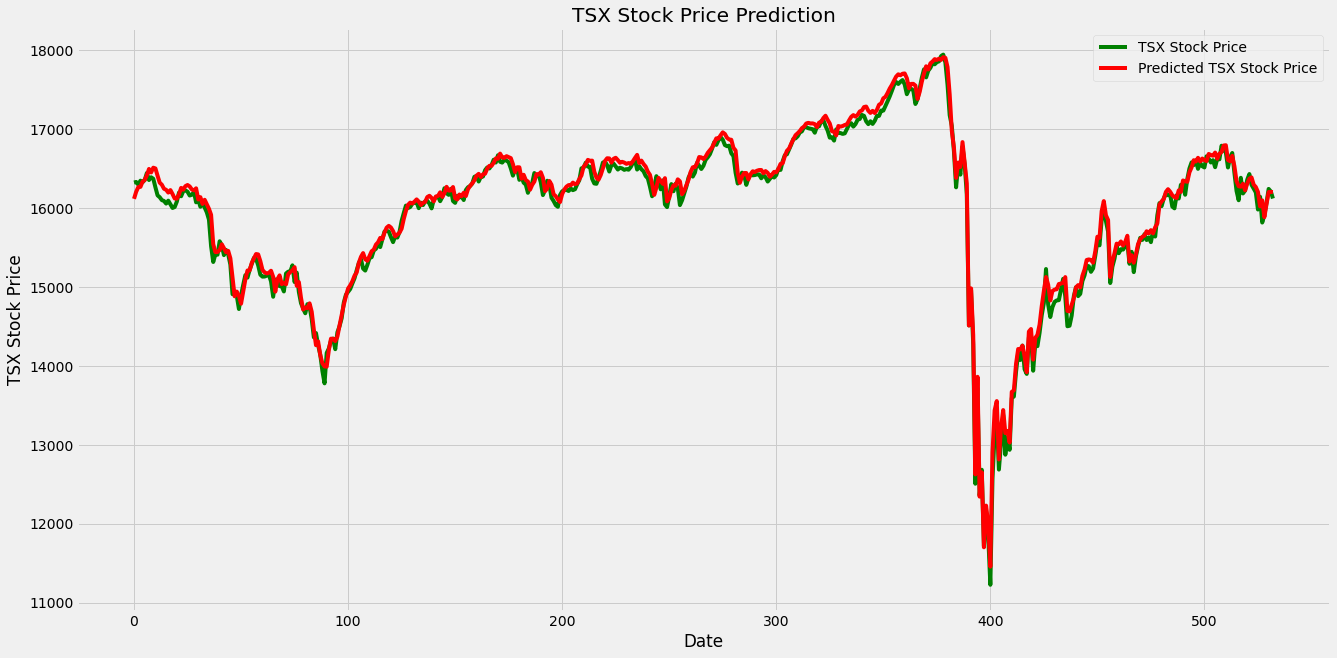

In [119]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'TSX Stock Price')
plt.plot(predicted_with_gru, color = 'red', label = 'Predicted TSX Stock Price')
plt.title('TSX Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('TSX Stock Price')
plt.legend()
plt.show()

In [120]:
rmse_predict1= np.reshape(predicted_with_gru,533)

In [121]:
#forecast metrics
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)
smape(test["Close"].values,rmse_predict1)

0.5143041587306517

In [122]:
#forecast metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mae = mean_absolute_error(test["Close"].values, rmse_predict1)
mse = mean_squared_error(test["Close"].values, rmse_predict1)
rmse = np.sqrt(mse) 


print("Results of sklearn.metrics:")
print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)


Results of sklearn.metrics:
MAE: 81.20319763660898
MSE: 10585.447468399412
RMSE: 102.88560379566916


In [123]:
elapsed_time = time.process_time() - t
print(elapsed_time)

30051.340034676992


In [124]:
#upload data to understand the relationship between canada's new covid cases and TSX price
#split data into 2 sections, test -> recent data from sept 8th onwards, train -> feb 1 to march 23rd
df=pd.read_csv("Canada Covid New Cases & Stock Price.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[150:]
train = df[:35]

In [125]:
import seaborn as sb

In [126]:
# when covid first started around feb, there was a relatively strong negative relationship between covid new cases vs stock price
pearsoncorr = train.corr(method='pearson')
pearsoncorr

,Sum of new_cases,TSX Price
Sum of new_cases,1.000000,-0.677857
TSX Price,-0.677857,1.000000


In [127]:
# as covid impact continues, there still is a egative relationship between covid new cases vs stock price, however the relationship is not as strong as the beginning of covid
pearsoncorr = test.corr(method='pearson')
pearsoncorr

,Sum of new_cases,TSX Price
Sum of new_cases,1.000000,-0.340568
TSX Price,-0.340568,1.000000


In [128]:
#upload data to understand the relationship between US's new covid cases and NASDAQ price
#split data into 2 sections, test -> recent data from sept 8th onwards, train -> feb 1 to march 23rd
df=pd.read_csv("USA Covid New Cases & Stock Price.csv", sep=",")
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
test = df[150:]
train = df[:35]

In [129]:
# when covid first started around feb, there was a relatively strong negative relationship between covid new cases vs stock price
pearsoncorr = train.corr(method='pearson')
pearsoncorr

,Sum of new_cases,Stock Price
Sum of new_cases,1.000000,-0.653411
Stock Price,-0.653411,1.000000


In [130]:
# as covid impact continues, there still is a egative relationship between covid new cases vs stock price, however the relationship is not as strong as the beginning of covid. The relationship is weaker in the US than Canada. 
pearsoncorr = test.corr(method='pearson')
pearsoncorr

,Sum of new_cases,Stock Price
Sum of new_cases,1.000000,-0.168529
Stock Price,-0.168529,1.000000
